# Vol of Vol Futures Investigation #

Nicholas Alexander njalex22@gmail.com

The purpose of this investigation is to analyze the futures ES, CL and GC and the vol of vol indexes for each of these futures to determine if they impact the directionality of the underlying futures. The notebook is organized as follows:

__1)__ Functions used to analyze the futures and vol of vol indexes

__2)__ Import, transform, format, and clean the data

__3)__ Investigate GC and Vol of GVZ (VGVZ)

__4)__ Investigate ES and VVIX

__5)__ Investigate CL and Vol of OVX (VOVX)

__6)__ Conclusion

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import functools
import ipdb
from pyfinance import ols
import statsmodels.api as sm
from IPython.display import display, clear_output
from statsmodels.tsa.stattools import grangercausalitytests
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
import warnings
from collections import Counter
from pyfinance import ols
import pandas_datareader.data as dr
import math
warnings.filterwarnings('ignore')

## 1. Functions used for analysis ##

This function queries data from Quandl based on its code and date.

In [55]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities, START,END):
#     print(len(my_securities))
#     print("Fetching from Quandl")
    quandl.ApiConfig.api_key = "XXXXXXXXXXXXXX"
    if len(my_securities) > 1:
        qdata = quandl.get(list(my_securities), start_date= START, end_date = END, returns="pandas")
    else:
        qdata = quandl.get(my_securities[0], start_date= START, end_date = END, returns="pandas")
    return qdata

This function transforms a volatility index into a vol of vol index based on the equation outlined in this paper on page 4:

https://www.cambridge.org/core/journals/journal-of-financial-and-quantitative-analysis/article/unknown-unknowns-uncertainty-about-risk-and-stock-returns/6E0E98349D20C1DCF67F3A0452361B80

In [56]:
def vv_transform(df):
    
    df['cumsum'] = df.rolling(20).mean()
    df['diff_sq'] = (df['Adj_Close'] - df['cumsum'])**2
    df['diff_sq_roll'] = df['diff_sq'].rolling(20).mean()
    df['Close'] = df['diff_sq_roll'] / df['cumsum']

    vv_df = df[['Close']].dropna(how='any')
    
    return vv_df, df

The plot_products function is used to plot the time series of prices for future and vol of vol index on one graph.

In [57]:
def plot_products(df1,df1_col,df1_name,df2,df2_col,df2_name,data_type):
    fig, (ax1) = plt.subplots()
    fig.set_size_inches(18,6)

#   plot the first data set  
    ax1.plot(df1.index,df1[df1_col],color='red')
    ax1.set_ylabel('{} {}'.format(df1_name,data_type))
    ax1.set_xlabel('Time')

#   declare two y axis  
    ax2 = ax1.twinx()

#   plot the second data set
    ax2.plot(df2.index,df2[df2_col],color='blue')
    ax2.set_ylabel('{} {}'.format(df2_name,data_type))
    ax2.set_title('{} and {} {}'.format(df1_name,df2_name,data_type))

    fig.legend([df1,df2], labels=[df1_name,df2_name],loc='upper left', bbox_to_anchor=[0.75,0.93])
    plt.tight_layout()
    plt.show()

The plot_rets function plots the daily returns for two different data sets.

In [58]:
def plot_rets(df1,df1_col,df1_name,df2,df2_col,df2_name,data_type):
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(18,7)

#   plot data set one  
    ax1.plot(df1.index,df1[df1_col],color='red')
    ax1.set_ylabel('{} {}'.format(df1_name,data_type))
    ax1.grid()

#   plot data set two  
    ax2.plot(df2.index,df2[df2_col],color='blue')
    ax2.set_ylabel('{} {}'.format(df2_name,data_type))
    ax2.set_xlabel('Time')
    ax2.grid()
    
    ax1.set_title('{} and {} {}'.format(df1_name,df2_name,data_type))
    plt.tight_layout()
    plt.show()

The plot_scatter_hist function creates a scatter plot for daily returns and histogram for one of the daily returns. Kurtosis and Skew are also computed for the data used in the histogram.

In [59]:
def plot_scatter_hist(df1,df1_col,df1_name,df2,df2_col,df2_name):
    
    fig2, (ax1,ax2) = plt.subplots(1,2)
    fig2.set_size_inches(22,5)
    
#   create the scatter plot  
    ax1.scatter(df1[df1_col],df2[df2_col],alpha=0.15)
    ax1.set_ylabel('{} Daily Return'.format(df2_name))
    ax1.set_xlabel('{} Daily Return'.format(df1_name))
    ax1.set_title('{} vs {}'.format(df1_name,df2_name))
    ax1.grid()
    
#   create the histogram
    ax2.hist(df1[df1_col], density=True, bins =50)
    ax2.set_title('Histogram of {} Daily Returns' .format(df1_name))
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Daily Return')
    ax2.grid()
    plt.show()
    
#   compute skewness and kurtosis for the data used in the histogram
    print("\n")
    print(f"{df1_name} Daily Return Skewness: {skew(df1[df1_col])}")
    print(f"{df1_name} Daily Return Kurtosis: {kurtosis(df1[df1_col])}")
    print("\n")
    
    plt.show()

The function computes the correlation matrix between two time series.

In [60]:
def plot_corr_matrix(df,corr_type,precision):

    corr = df.corr(method=corr_type).round(precision)
    display(corr.style.background_gradient(cmap='coolwarm').set_precision(precision))

This function computes the Hurst Exponent. This code used from link below.

https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/

In [61]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

This function prints the descriptive statistics of the future close prices, and analyzes the overlapping dates between the future and its corresponding vol of vol index. Finally, it calls plot_products function.

In [62]:
def vv_viz(future_df,future_name,future_col,vv_df,vv_name,vv_col):

    print("Data Check for sufficient overlap of dates")
    print("") 
    
    #   identify overlapping dates  
    inter = list(set(vv_df[[vv_col,'Pct_Change']].dropna().index) & set(future_df[[future_col,'Pct_Change']].dropna().index))
    
    print(f"The number of dates not shared is {len(set(vv_df.index).symmetric_difference(future_df.index))}")
    print(f"The number of dates shared is {len(inter)}")
    
    #   filter by overlapping dates  
    future_df2 = future_df[future_df.index.isin(inter)]
    vv_df2 = vv_df[vv_df.index.isin(inter)]
    
        #   display data stats  
    print(f"The descriptive statistics for {future_name} are found below:")
    print("")
    display(future_df2.describe())
    
    #   plot time series 
    plot_products(future_df2,future_col,future_name,vv_df2,vv_col,vv_name,'Close Price')
    
    return vv_df2, future_df2

This function calls the plot_rets and plot_corr_hist functions. Additionally, it computes the linear and rank correlation between the daily returns of the future and its corresponding vol of vol index.

In [63]:
def vv_corr_hist(future_df,future_name,future_col,vv_df,vv_name,vv_col):
    
    #   identify overlapping dates  
    inter = list(set(vv_df[[vv_col,'Pct_Change']].dropna().index) & set(future_df[[future_col,'Pct_Change']].dropna().index))
    
    #   filter by overlapping dates  
    future_df2 = future_df[future_df.index.isin(inter)]
    vv_df2 = vv_df[vv_df.index.isin(inter)]
    
    #   plot returns  
    plot_rets(future_df2,'Pct_Change',future_name,vv_df2,'Pct_Change',vv_name,'Daily Return')
    
#   plot histogram and scatter plots  
    plot_scatter_hist(future_df2,'Pct_Change',future_name,vv_df2,'Pct_Change',vv_name)
      
#   construct matrix for correlation analysis
    data = pd.concat([future_df2['Pct_Change'],vv_df2['Pct_Change']],axis=1)
    data.columns = [future_name,vv_name]
    
#   compute linear and rank correlation  
    print(f"Linear correlation of Returns between {vv_name} and {future_name}")
    plot_corr_matrix(data,'pearson',5)
    print("\n")
    
    print(f"Rank correlation of Returns between {vv_name} and {future_name}")
    plot_corr_matrix(data,'kendall',5)
    print("\n")
    
    return vv_df2, future_df2

This function computes the granger casuality test of the daily returns of the future and its corresponding vol of vol index. Furthermore, three mean reversion tests are conducted for the vol of vol index; the ADF Test, the KPSS Test and the Hurst Exponent.

In [64]:
def vv_granger_mr(future_df,future_name,future_col,vv_df,vv_name,vv_col,lag_num):
    
    #   identify overlapping dates  
    inter = list(set(vv_df[[vv_col,'Pct_Change']].dropna().index) & set(future_df[[future_col,'Pct_Change']].dropna().index))
    
    #   filter by overlapping dates  
    future_df2 = future_df[future_df.index.isin(inter)]
    vv_df2 = vv_df[vv_df.index.isin(inter)]
    
    #   construct matrix for granger causality test  
    data = pd.concat([future_df2['Pct_Change'],vv_df2['Pct_Change']],axis=1)
    data.columns = [future_name,vv_name]
       
#   conduct GC test
    granger_gc = grangercausalitytests(data, lag_num)
    
#   identify lag with lowest average p value
    sums = []
    for y in granger_gc.keys():

        gc_sum = 0
        for x in granger_gc[y][0].keys():
            gc_sum += granger_gc[y][0][x][1]

        sums.append(gc_sum/4)

    lags = np.argmin(sums) + 1
    
    print("\n")
    print(f"The smallest p value corresponds to {lags} lags.")
    print("\n")
    
#   Test for a unit root of the vol of vol index price  
    
    print("**** Augemented Dickey Fuller Test *****")
    print("")
    
    result = adfuller(vv_df2[vv_col])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print("")
    
    if result[1] < 0.05:
        print("The p Value falls below the 0.05 threshold, therefore, the null hypothesis that there exists a unit root is rejected.")
    else:
        print("The p Value exceeds the 0.05 threshold, therefore, the null hypothesis that there exists a unit root is not rejected.")
        
    print("")
    
    print("**** KPSS Test *****")
    print("")
    
#   Test for stationarity of the vol of vol index price using the KPSS test

    statistic, p_value, n_lags, critical_values = kpss(vv_df2[vv_col],regression='c')
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print("")
    
    if p_value < 0.05:
        print("The p Value falls below the 0.05 threshold, therefore, the null hypothesis that the time series is stationary is rejected.")
    else:
        print("The p Value exceeds the 0.05 threshold, therefore, the null hypothesis that the time series is stationary is not rejected.")
    
    print("")
    
    print("**** Hurst Exponent Analysis *****")
    print("")
    
#   Test for Hurst Exponent
    h_exp = hurst(vv_df2[vv_col])
    print(f"Hurst Exponent: {h_exp}")
    print("")
    
    if h_exp < 0.4995:
        print("The Hurst exponent falls below the 0.5 threshold, therefore, this metric suggests the time series is stationary.")
    elif h_exp > 0.5005:
        print("The Hurst exponent exceeds the 0.5 threshold, therefore, this metric suggests the time series is trending and therefore, not stationary.")
    else:
        print("The Hurst exponent meets the 0.5 threshold, therefore, this metric suggests the time series demonstrates geometric brownian motion and is not stationary.")
        
    print("")
    
    return vv_df2, future_df2

## 2. Import, transform, format, and clean the data

Import the three futures contracts, ES, CL and GC from Quandl. Compute the percent change of their close prices.

In [65]:
quandl.ApiConfig.api_key ="q8325ZULJEu9Kty5BczR"
gc_df = fetch_quandl(('CHRIS/CME_GC1',),START='2007-01-03',END='2020-12-11')
es_df = fetch_quandl(('CHRIS/CME_ES1',),START='2007-01-03',END='2020-12-11')
cl_df = fetch_quandl(('CHRIS/CME_CL1',),START='2007-01-03',END='2020-12-11')

es_df['Pct_Change'] = es_df['Settle'].pct_change()
gc_df['Pct_Change'] = gc_df['Settle'].pct_change()
cl_df['Pct_Change'] = cl_df['Settle'].pct_change()

Import the volatility indexes for gold and oil, GVZ and OVX from FRED. Compute their corresponding volatility indexes and daily returns.

Compute Vol of OVX (VOVX) and Vol of GVZ (VGVZ).

In [66]:
# Drop holidays which are included in the FRED database
gvz_raw = dr.DataReader("GVZCLS","fred",start = '2008-06-03', end = '2020-12-11')
ovx_raw = dr.DataReader("OVXCLS","fred",start = '2007-05-10', end = '2020-12-11')

gvz_raw.columns = ['Adj_Close']
ovx_raw.columns = ['Adj_Close']

gvz_df = gvz_raw[['Adj_Close']].dropna(how='any')
ovx_df = ovx_raw[['Adj_Close']].dropna(how='any')

# compute the volatility indexes for GVZ and OVX
vgvz_df, check = vv_transform(gvz_df)
vovx_df, check = vv_transform(ovx_df)

# compute daily returns
vgvz_df['Pct_Change'] = vgvz_df['Close'].pct_change()
vovx_df['Pct_Change'] = vovx_df['Close'].pct_change()

Obtained VVIX data from Yahoo Data as it was not available on Quandl or FRED. Daily returns are also computed.

In [67]:
vvix_df = pd.read_csv("VVIX.csv")

vvix_df.index = pd.to_datetime(vvix_df['Date'])
vvix_df.drop(['Date'],inplace=True,axis=1)
vvix_df.rename(columns={'Adj Close':'Adj_Close'},inplace=True);

vvix_df['Pct_Change'] = vvix_df['Adj_Close'].pct_change()

## 3. Analysis of GC and VGVZ

Data Check for sufficient overlap of dates

The number of dates not shared is 410
The number of dates shared is 3105
The descriptive statistics for GC are found below:



,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Pct_Change
count,3068.000000,3071.000000,3073.000000,3075.000000,1710.000000,3105.000000,3105.000000,3105.000000,3105.000000
mean,1331.543840,1340.473754,1321.887732,1331.363024,7.770702,1331.050081,64122.687923,80951.180676,0.000287
std,251.726898,252.949704,249.814473,251.521782,10.589972,250.390777,101495.788840,120346.905402,0.011445
min,705.000000,719.800000,681.000000,705.000000,-97.300000,705.000000,0.000000,1.000000,-0.093538
25%,1198.075000,1205.550000,1191.000000,1197.850000,2.425000,1198.700000,175.000000,736.000000,-0.004974
50%,1287.850000,1293.800000,1281.400000,1287.700000,5.650000,1288.000000,1144.000000,3875.000000,0.000357
75%,1497.425000,1506.200000,1486.200000,1497.350000,10.900000,1495.800000,131069.000000,171788.000000,0.005877
max,2045.500000,2063.000000,2040.000000,2058.300000,93.200000,2051.500000,796390.000000,552956.000000,0.090078


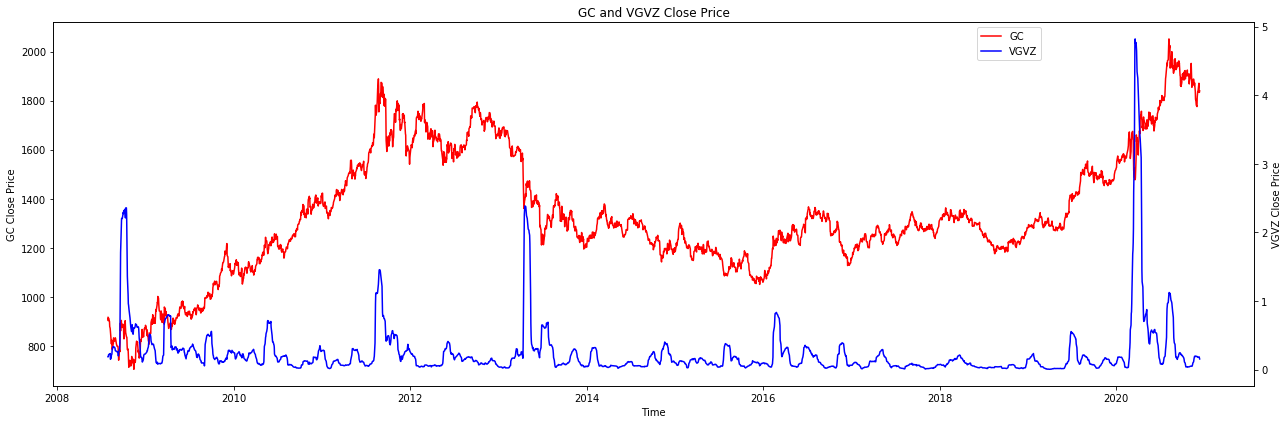

In [22]:
vv_viz(future_df=gc_df,future_name='GC',future_col='Settle',vv_df=vgvz_df,vv_name='VGVZ',vv_col='Close');

The descriptive statistics do not appear to provide any unexpected results. There were roughly 400 days where GC and VGVZ do not overlap because data for GVZ begins over a year later than GC and 40 additional days are lost to moving average calculations when constructing the vol of vol index. Visual inspection of the time series plot of GC and VGVZ do not appear to demonstrate a clear relationship in the data. The three largest spikes in volatility occur during a GC uptrend, downtrend and uptrend.

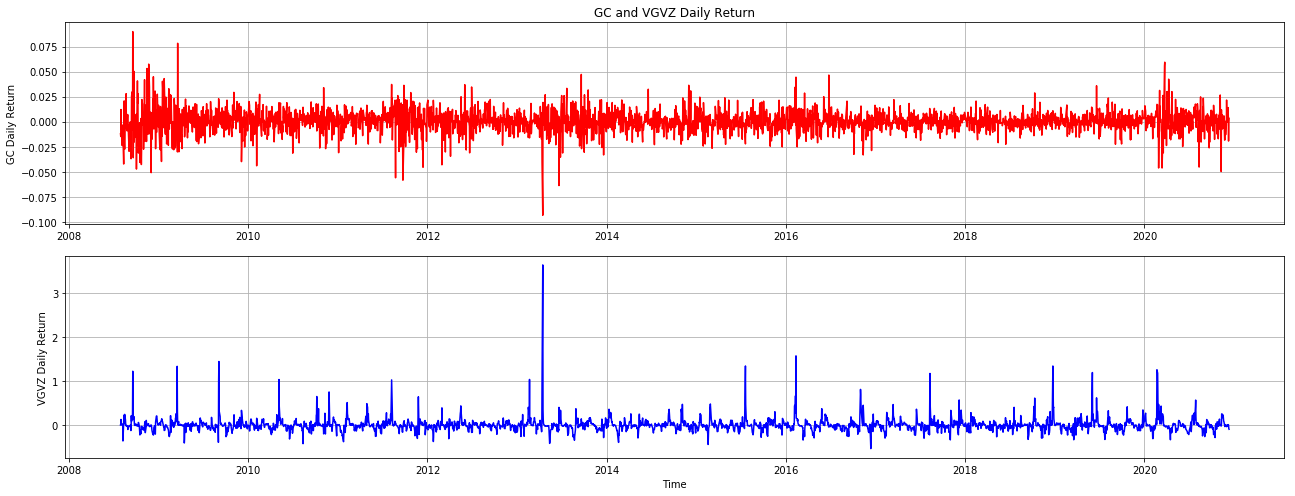

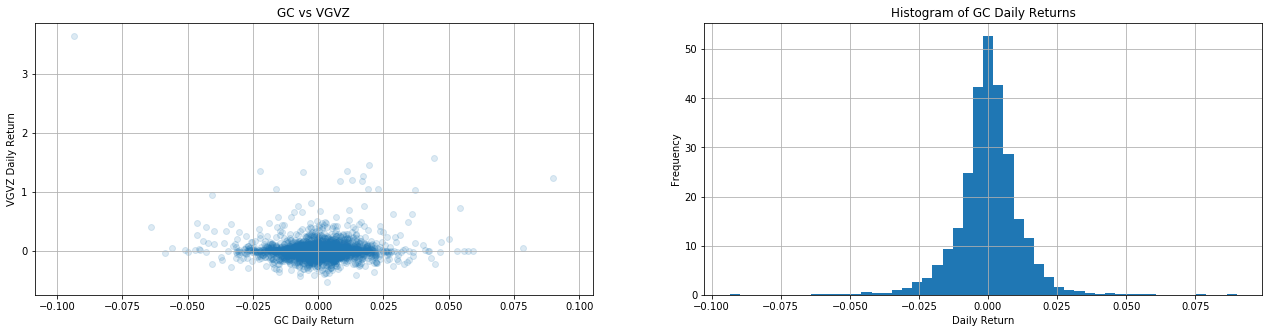



GC Daily Return Skewness: -0.03659937584461897
GC Daily Return Kurtosis: 6.370489605921438


Linear correlation of Returns between VGVZ and GC


,GC,VGVZ
GC,1,-0.00456
VGVZ,-0.00456,1




Rank correlation of Returns between VGVZ and GC


,GC,VGVZ
GC,1,0.00534
VGVZ,0.00534,1


In [24]:
vv_corr_hist(future_df=gc_df,future_name='GC',future_col='Settle',vv_df=vgvz_df,vv_name='VGVZ',vv_col='Close');

Next, daily returns of the GC and VGVZ are analyzed. Time series plots, pairwise correlation, and a histogram of GC daily returns are plotted. The pairwise correlation graph suggests there is not a linear or non linear relationship between the daily returns of GC and VGVZ. The linear and rank correlation is computed to be roughly zero, reinforcing the fact that there is no discernable relationship. Finally, the histogram of the GC daily returns yields a skewness of -0.03 and kurtosis of 6.37, meaning the histogram is symmetric like a normal distribution but has fatter tails.

In [25]:
vv_granger_mr(future_df=gc_df,future_name='GC',future_col='Settle',vv_df=vgvz_df,vv_name='VGVZ',vv_col='Close',lag_num=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9046  , p=0.0884  , df_denom=3101, df_num=1
ssr based chi2 test:   chi2=2.9075  , p=0.0882  , df=1
likelihood ratio test: chi2=2.9061  , p=0.0882  , df=1
parameter F test:         F=2.9046  , p=0.0884  , df_denom=3101, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5697  , p=0.2083  , df_denom=3098, df_num=2
ssr based chi2 test:   chi2=3.1445  , p=0.2076  , df=2
likelihood ratio test: chi2=3.1429  , p=0.2077  , df=2
parameter F test:         F=1.5697  , p=0.2083  , df_denom=3098, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0358  , p=0.3755  , df_denom=3095, df_num=3
ssr based chi2 test:   chi2=3.1143  , p=0.3743  , df=3
likelihood ratio test: chi2=3.1127  , p=0.3746  , df=3
parameter F test:         F=1.0358  , p=0.3755  , df_denom=3095, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9397  , p=0.

Finally, I investigate the granger casuality of GC and VGVZ, and the mean reversion of the VGVZ. The granger casuality determines when the past values of one of the time series has a statistically significant effect on the current values of the other time series. The null hypothesis is that there is no effect. For lags 1 to 5 the null hypothesis is not rejected, meaning that past values of the daily return for VGVZ does not have a statistically significant effect on the current return of GC.

The first mean reversion test is the Augmented Dickey Fuller(ADF) Test. The null hypothesis is that the time series has a unit root and, therefore, follows a random walk process. The alternative hypothesis is that there is not a unit root, the process is stationary and therefore has mean reversion properties. The ADF null hypothesis is clearly rejected, suggesting the VGVZ has mean reversion properties.

The second test is the KPSS test. The null hypothesis is that the time series is stationary and the alternative hypothesis is the time series is not stationary. The null hypothesis is not rejected, therefore, the KPSS test concludes the time series is stationary.

The third test is the Hurst Exponent. A value above 0.5 suggests a trending time series that is not stationary. A value below 0.5 suggests a stationary time series. This test yields a value below 0.5, therefore, the Hurst Exponent concludes the time series is stationary and, therefore, demonstrates mean reversion behavior.

Clearly, the VGVZ is mean reverting, which is a common behavior exploited in a trading strategy. The primary problem is that there does not appear to be any clear relationship between GC and VGVZ upon which to identify buy and sell signals. The correlation analysis clearly concludes there is no relationship between GC and VGVZ. Granger casuality does not identify a statistically significant relationship for lags 1 to 5. Finally, visual inspection of the time series does not demonstrate any clear relationship. For these reasons, it is concluded there is not a strategy to be developed for these products. While this does not rule out the possibility that a profitable strategy could be developed, it would require further in depth research which is out of the scope of this higher level investigation. This research would include additional statistical tests, time series forecasting models and additional data sources to serve as indicators. 

## 4. Analysis of ES and VVIX ##

Data Check for sufficient overlap of dates

The number of dates not shared is 44
The number of dates shared is 3508
The descriptive statistics for ES are found below:



,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Pct_Change
count,3508.000000,3508.000000,3508.000000,3508.000000,1683.000000,3508.000000,3.508000e+03,3.508000e+03,3508.000000
mean,1882.266462,1895.894313,1868.256628,1883.476921,15.891087,1883.437480,1.691722e+06,2.569677e+06,0.000394
std,696.190345,699.974516,692.849874,697.159219,24.013416,697.106881,7.703450e+05,5.137754e+05,0.013192
min,674.750000,694.750000,665.750000,676.000000,-119.500000,676.000000,1.970300e+04,5.134270e+05,-0.103765
25%,1318.500000,1328.500000,1308.000000,1318.750000,3.750000,1318.750000,1.189356e+06,2.447954e+06,-0.004037
50%,1795.625000,1806.500000,1786.250000,1797.250000,10.000000,1797.250000,1.598650e+06,2.708256e+06,0.000762
75%,2422.250000,2435.187500,2403.375000,2424.062500,21.750000,2424.625000,2.078068e+06,2.887919e+06,0.005759
max,3707.750000,3714.750000,3672.250000,3703.000000,279.750000,3702.000000,6.285917e+06,3.594453e+06,0.141134


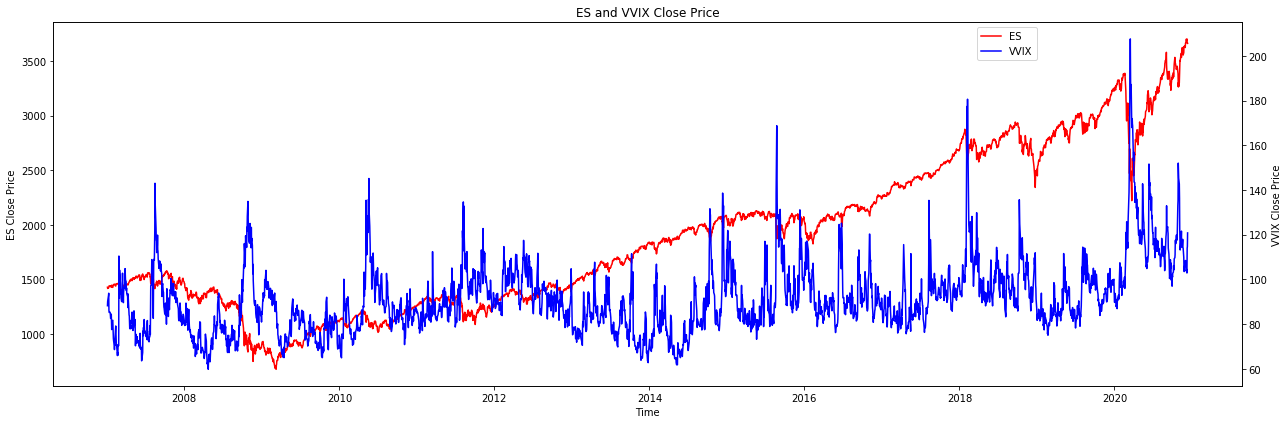

In [26]:
vv_viz(future_df=es_df,future_name='ES',future_col='Settle',vv_df=vvix_df,vv_name='VVIX',vv_col='Adj_Close');

The investigation of ES and VVIX starts with the descriptive statistics of the ES, the overlapping dates and time series plots. The standard deviation of the ES close price is quite high at 696 considering ES demonstrates a steady upwards trend for the majority of the time series. This standard deviation likely comes from the sharp market swings in 2009 and 2020. The dates for both time series are very closely aligned, as expected, given the time frame of both data sets are aligned. 

Intuition says that large spikes in volatility correspond to sharp market contractions. Similarly, periods of low volatility typically correspond to market expansion. This behavior is largely described by the leverage effect and can be observed in this time series plot. There are roughly 7 spikes in volatility that correspond to ES price drops. ES price increases and low VVIX are less obvious, but it is more evident during the second half of the time series. The daily return graph shows increased price movements during the Financial crash and pandemic, as expected.

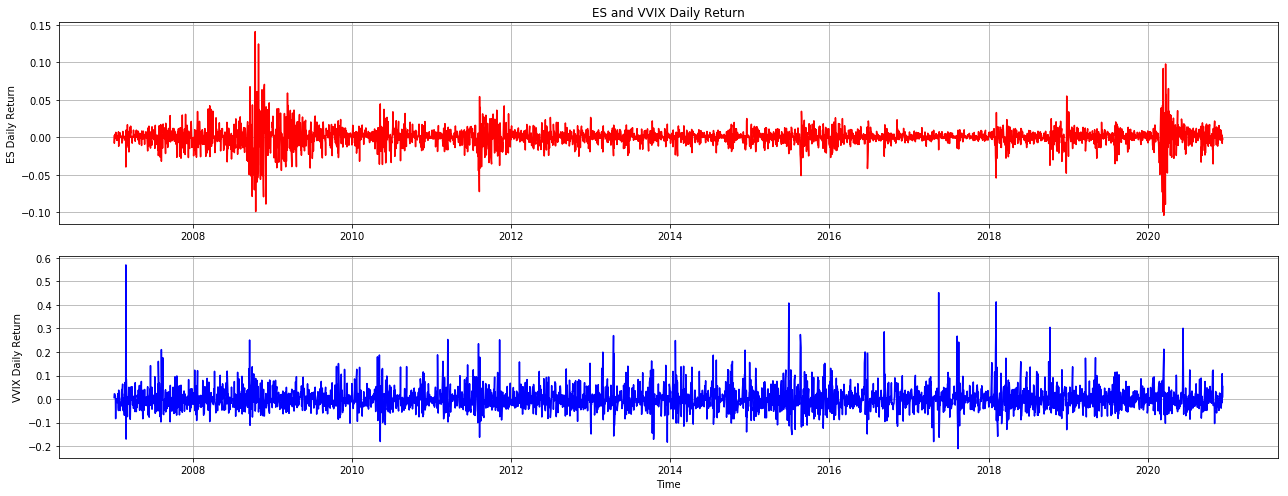

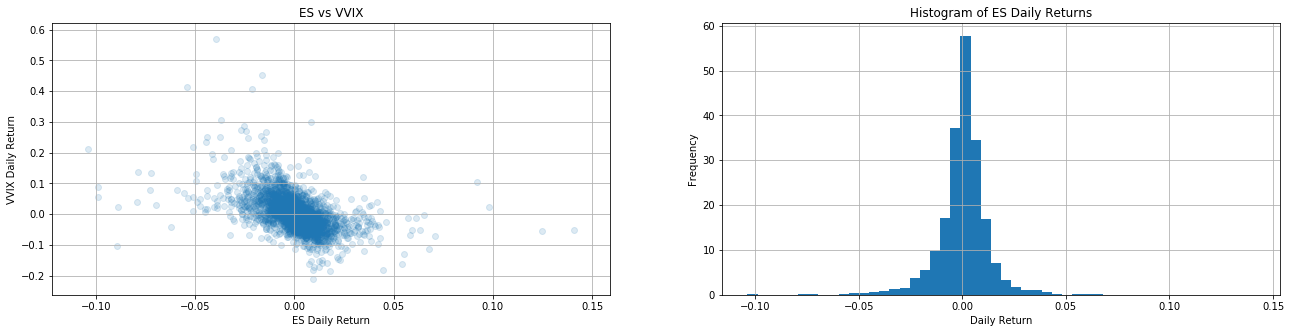



ES Daily Return Skewness: -0.07356919805859055
ES Daily Return Kurtosis: 14.999479946605835


Linear correlation of Returns between VVIX and ES


,ES,VVIX
ES,1,-0.51465
VVIX,-0.51465,1




Rank correlation of Returns between VVIX and ES


,ES,VVIX
ES,1,-0.42882
VVIX,-0.42882,1


In [27]:
vvix_filter,es_filter = vv_corr_hist(future_df=es_df,future_name='ES',future_col='Settle',vv_df=vvix_df,vv_name='VVIX',vv_col='Adj_Close');

Investigation of the correlation scatterplot and correlation computation confirm the behavior observed in the time series plot. The scatter plot clearly demonstrates a negative relation around the most dense portion of the graph. The linear and rank correlation results are consistent with this notion of a strong negative relationship. The rank correlation adds an additional piece of information in that the measure is less sensitive to outliers, therefore, filtering out potential noise to yield the true behavior.

The histogram of ES daily returns are symmetric similar to a normal distribution due to the roughly zero skewness, however, the tails are much fatter. This is expected to observe fat tails, especially due to the sharp drops in ES observed in the time series graph.

In [28]:
vv_granger_mr(future_df=es_df,future_name='ES',future_col='Settle',vv_df=vvix_df,vv_name='VVIX',vv_col='Adj_Close',lag_num=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0802  , p=0.0435  , df_denom=3504, df_num=1
ssr based chi2 test:   chi2=4.0837  , p=0.0433  , df=1
likelihood ratio test: chi2=4.0813  , p=0.0434  , df=1
parameter F test:         F=4.0802  , p=0.0435  , df_denom=3504, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5841  , p=0.0038  , df_denom=3501, df_num=2
ssr based chi2 test:   chi2=11.1841 , p=0.0037  , df=2
likelihood ratio test: chi2=11.1663 , p=0.0038  , df=2
parameter F test:         F=5.5841  , p=0.0038  , df_denom=3501, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1941  , p=0.0057  , df_denom=3498, df_num=3
ssr based chi2 test:   chi2=12.6075 , p=0.0056  , df=3
likelihood ratio test: chi2=12.5849 , p=0.0056  , df=3
parameter F test:         F=4.1941  , p=0.0057  , df_denom=3498, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5646  , p=0.

This relationship is further explored through the granger causality test. For all instances of varying lags of 1 to 5, we can reject the null hypothesis that past values of VVIX do not have a statistically significant effect on the current values of ES. This further supports the notion of a strong negative relationship between VVIX and ES.

One property of volatility is that it is mean reverting in the long run. However, it is not guarenteed that it is mean reverting for any time horizon. Mean reversion is a property that can be utilized to build an effective trading strategy, so we next investigate mean reversion for the VVIX. 

Three tests are used to investigate mean reversion, the ADF Test, the KPSS test and the Hurst Exponent. The ADF test clearly rejects the null hypothesis of a unit root, meaning the time series does not behave as a random walk, is stationary, and demonstrates mean reversion. The KPSS rejects the null hypothesis that the time series is level stationary. Finally, the Hurst Exponent falls below the 0.5 threshold, concluding the time series is mean reverting. Overall, two of the three tests support mean reversion which allows us to conclude in a reasonably confident manner that VVIX is mean reverting for this time horizon.

Intution and visual inspection of the time series suggest the relationship between ES and VVIX are not the same for days of ES increases compared to ES declines, therefore, this relationship is further explored. The relationship between ES and VVIX will be re-examined for positive and negative daily ES returns for the purpose of developing buy and sell signals which better capture the behavior of ES and VVIX.

In [29]:
# divide data into positive and negative daily returns for ES
es_pos = es_filter[es_filter['Pct_Change'] >= 0][['Pct_Change','Settle']]
es_neg = es_filter[es_filter['Pct_Change'] < 0][['Pct_Change','Settle']]

# filter by the same time index for VVIX
vvix_pos = vvix_filter.loc[es_pos.index,:][['Pct_Change','Adj_Close']]
vvix_neg = vvix_filter.loc[es_neg.index,:][['Pct_Change','Adj_Close']]

# merge data and rename columns
vvix_es_neg = pd.merge(es_neg,vvix_neg, how='inner', left_index=True, right_index=True)
vvix_es_pos = pd.merge(es_pos,vvix_pos, how='inner', left_index=True, right_index=True)

# rename columns for positive and negative days
vvix_es_neg.columns = ['ES','Settle','VVIX','Adj_Close']
vvix_es_pos.columns = ['ES','Settle','VVIX','Adj_Close']

First, linear and rank correlations are examined.

In [30]:
print("Linear Correlation for positive return days:")
plot_corr_matrix(vvix_es_pos[['ES','VVIX']],'pearson',4)

print("Linear Correlation for negative return days:")

plot_corr_matrix(vvix_es_neg[['ES','VVIX']],'pearson',4)

Linear Correlation for positive return days:


,ES,VVIX
ES,1,-0.2528
VVIX,-0.2528,1


Linear Correlation for negative return days:


,ES,VVIX
ES,1,-0.3939
VVIX,-0.3939,1


The linear correlation clearly shows the negative relationship is stronger for days when the ES experiences a negative return. This is consistent without our observation of sharp declines in ES coresponding to spikes in VVIX. While there still appears to be a negative relationship between ES and VVIX for days of positive ES return, the relationship is clearly less evident.

In [31]:
print("Rank Correlation for positive return days:")
plot_corr_matrix(vvix_es_pos[['ES','VVIX']],'kendall',4)

print("Rank Correlation for negative return days:")
plot_corr_matrix(vvix_es_neg[['ES','VVIX']],'kendall',4)

Rank Correlation for positive return days:


,ES,VVIX
ES,1,-0.2658
VVIX,-0.2658,1


Rank Correlation for negative return days:


,ES,VVIX
ES,1,-0.3082
VVIX,-0.3082,1


The rank correlation reaffirms the results of the linear correlation. While the difference is less, the negative relationship is still stronger for days of ES decline when outliers are discounted.

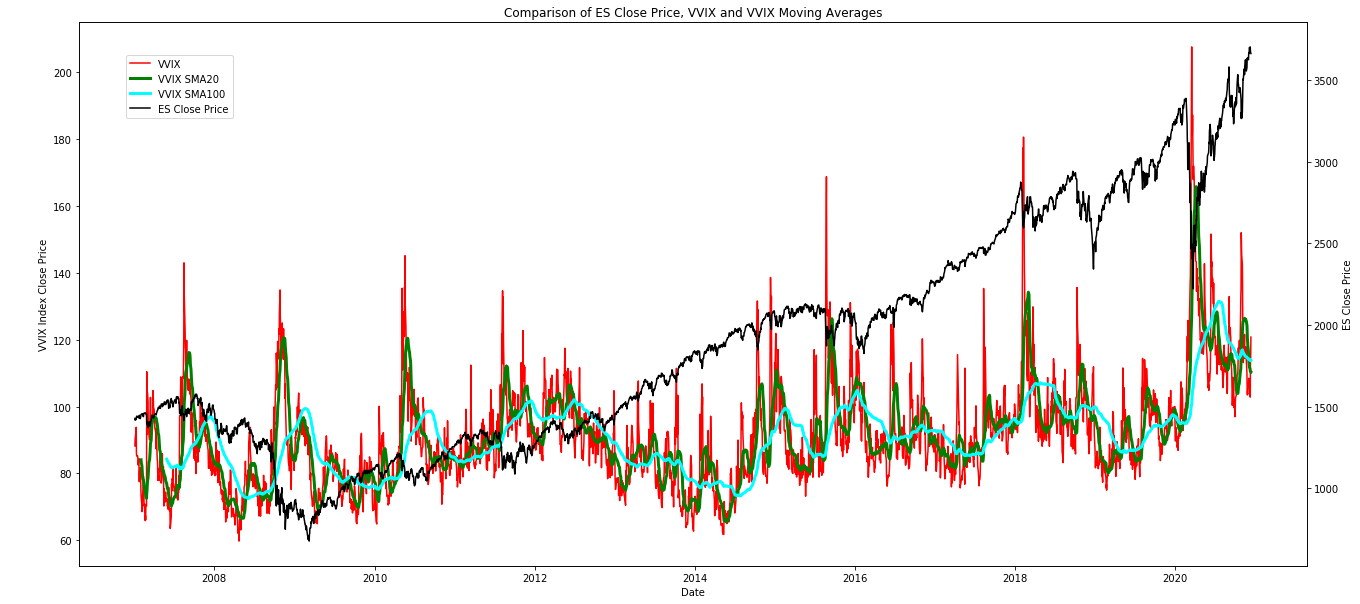

In [83]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(22, 10)

ax2 = ax1.twinx()

ax1.plot(vvix_filter.index,vvix_filter['Adj_Close'],color='red')
ax1.plot(vvix_filter.index,vvix_filter['Adj_Close'].rolling(20).mean(),color='green',linewidth=3)
ax1.plot(vvix_filter.index,vvix_filter['Adj_Close'].rolling(100).mean(),color='cyan',linewidth=3)
ax1.set_ylabel('VVIX Index Close Price')
ax1.set_xlabel('Date')

ax2.plot(es_filter.index,es_filter['Settle'],color='black')
ax2.set_ylabel('ES Close Price')
ax2.set_title('Comparison of ES Close Price, VVIX and VVIX Moving Averages')

fig.legend(labels=['VVIX','VVIX SMA20','VVIX SMA100','ES Close Price'], bbox_to_anchor=[0.15,0.77])
plt.show()

Using this correlation information for days of positive and negative daily ES returns, buy and sell signals can be developed.

The indicators developed for this trading strategy will utilize the mean reverting properties of the VVIX. Quantiles of the VVIX SMA20 are computed  and when VVIX exceeds the 90% quantile, we can assume it will revert can to the mean in the near future. The same is true for the when VVIX falls below the 40th quantile. The 40th quantile is used for the sell signals to provide the opportunity to trigger more sell signals during periods of when VVIX is more volatile. Given the VVIX is quite a noisey signal, I compute these quantiles based on the SMA20 of the VVIX.

The purpose of this strategy is to identify the peaks of the VVIX and take a long position in ES slightly after the peak is observed. This is because based on the historical data, a peak in VVIX, appears to precede a trough in ES, however, the trough of ES is slightly after the peak. This demonstrates the predictive power of the VVIX indicator.  I identify the peak based on two indicators. The first is the SMA20 must exceed the 90th quantile to prove this is a significant peak which typically precedes a price decline. Next, I compute the difference between the VVIX SMA20 and SMA100. When the current difference is less than the previous days difference, I determine I have reached a peak and, therefore, take a long position in ES. This buy signal is triggered the first day the difference in these moving averages converge, because ES reacts very quickly to a spike in VVIX.

For the sell signal I compute the rolling 25 day OLS beta for the VVIX SMA100. When I observe a rolling beta of -1 or less and VVIX to be below its 40th quantile, I conclude volatility has been low for a long enough time that ES price has likely risen to the point of creating a selling opportunity. This signal requires the described behavior to be established for a longer period of time, as the relationship between VVIX and ES during declines in VVIX does not manifest its as quickly.


## ES Trading Signals ##

In [34]:
vvix_format = vvix_df[['Adj_Close']]
vvix_format.rename(columns={'Adj_Close':'Index_Close'},inplace=True);

es_format = es_df[['Volume','Previous Day Open Interest','Settle','Pct_Change']]

# Merge ES and VVIX data
merge = pd.merge(vvix_format,es_format, how='inner', left_index=True, right_index=True)
vvix_es = merge.dropna(how='any')

The quantiles of VVIX are as follows:

In [35]:
pd.DataFrame(vvix_es['Index_Close'].rolling(20).mean().quantile(np.arange(0.1,1.0,0.1)))

,Index_Close
0.1,75.024200
0.2,81.068700
0.3,83.946600
0.4,86.243400
0.5,89.154499
0.6,92.777799
0.7,95.936300
0.8,100.171200
0.9,107.991500


Compute the trading signal indicators.

In [36]:
# compute the SMA
vvix_es['VV_SMA20'] = vvix_es['Index_Close'].rolling(20).mean()
vvix_es['VV_SMA100'] = vvix_es['Index_Close'].rolling(100).mean()

# Comptue rolling beta
rolling = ols.PandasRollingOLS(y=vvix_es['Index_Close'], x= np.arange(0,len(vvix_es['VV_SMA100']),1), window=25)
vvix_es['Rolling_Beta'] = rolling.beta

# Identify difference between SMA20 and SMA100
vvix_es['VV_SMA_Location'] = vvix_es['VV_SMA20'] - vvix_es['VV_SMA100']

# Define upper and lower thresholds as 90% and 10% percentle of SMA20. Include intermediate quantiles for future investigation
upper_band1 = 107.99
upper_band2 = 100.17
lower_band1 = 86.24
lower_band2 = 75.02

vvix_es['VV_Location'] = np.where(vvix_es['VV_SMA20'] > upper_band1, 5, 
                                 np.where(vvix_es['VV_SMA20'] > upper_band2, 4,
                                 np.where(vvix_es['VV_SMA20'] > lower_band1, 3,
                                 np.where(vvix_es['VV_SMA20'] > lower_band2, 2, 1))))
vvix_es['Trade'] = 0
vvix_es['Position'] = 0

In [37]:
vvix_es.drop(['VV_SMA20','VV_SMA100'],axis=1,inplace=True)
vvix_es.dropna(how='any',inplace=True)

Run the trading simulation to identify buy and sell signals.

In [38]:
trade_df = vvix_es.reset_index()

for index, row in trade_df.iloc[:,:].iterrows():
    
    if index == 0:
        continue 
        
#   logic to send a buy signal  
    if row['VV_Location'] == 5 and (row['VV_SMA_Location'] < trade_df.loc[index-1,'VV_SMA_Location']):
        trade_df.loc[index,'Trade'] = 1
       
#   logic to send a sell signal  
    elif row['VV_Location'] == 2 and (row['Rolling_Beta'] <= -1):
        trade_df.loc[index,'Trade'] = -1
      
# create dataframes for buy and sell signals to visualize
buy = trade_df[trade_df['Trade'] == 1]
sell = trade_df[trade_df['Trade'] == -1]

Plot the buy and sell signals over the time series graph of ES to evaluate the timing of these signals.

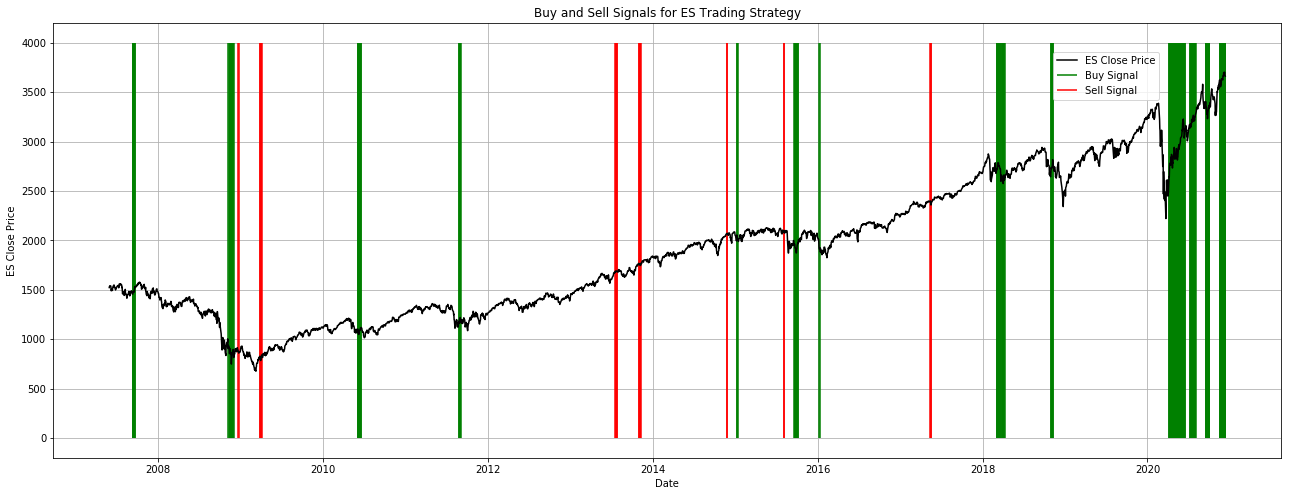

In [39]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(22, 8)


ax1.plot(trade_df['Date'],trade_df['Settle'],color='black')
ax1.vlines(x=buy['Date'],ymin=0,ymax=4000,color='g')
ax1.vlines(x=sell['Date'],ymin=0,ymax=4000,color='r')
ax1.set_xlabel('Date')
ax1.set_ylabel('ES Close Price')
ax1.set_title('Buy and Sell Signals for ES Trading Strategy')

fig.legend(labels=['ES Close Price','Buy Signal','Sell Signal'], bbox_to_anchor=[0.735,0.78])
ax1.grid()
plt.show()

This graph displays the buy and sell signals for ES based on the VVIX indicators. Inspection of the buy signals reveals this strategy does a pretty good job of identifying periods of decline for ES, with the exception of the first buy signal. The periods following these buy signals almost always result in upward price trend for ES. This is consistent with the goal of buying low. 

The sell signals are slightly less successful. With the exeception of the first two sell signals, the remaining sell signals typically trigger during a period of positive ES price trend. While they do not trigger right before a crash, they are typically triggered after a reasonable period of ES price increase. This is a result of the sell logic only triggered after a sustained period of low volatility for the VVIX SMA100.

It is important to note that these quantiles were generated using the entire data set, meaning lookahead bias was introduced into this strategy. However, given I have established that VVIX demonstrates mean reversion, it is reasonable to expect these quantiles to hold in the future. Additionally, these signals were developed and tested on the same exact data, therefore, these signals must be tested next on out of sample data, once it is available. Furthermore, these signals do not consider trading sizes, position limits, trading costs or slippage. Each of these points would need to be analyzed and accounted for when developing a finalized strategy.

## 5. Analysis of CL and VOVX ##

Data Check for sufficient overlap of dates

The number of dates not shared is 136
The number of dates shared is 3384
The descriptive statistics for CL are found below:



,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Pct_Change
count,3384.000000,3384.000000,3384.000000,3384.000000,1711.000000,3384.000000,3.384000e+03,3384.000000,3384.000000
mean,71.780287,72.835957,70.621868,71.760564,0.926686,71.751315,3.752271e+05,278566.108747,-0.000815
std,24.219793,24.324998,24.126431,24.236313,1.961594,24.269234,2.134597e+05,148384.192031,0.063599
min,-14.000000,13.690000,-40.320000,-13.100000,-3.010000,-37.630000,5.000000e+01,13044.000000,-3.059661
25%,50.790000,51.745000,49.850000,50.770000,0.290000,50.745000,2.318608e+05,165511.500000,-0.011908
50%,70.300000,71.380000,69.095000,70.220000,0.670000,70.290000,3.173715e+05,288000.000000,0.000415
75%,93.232500,94.152500,92.052500,93.197500,1.240000,93.190000,5.016770e+05,373016.000000,0.012286
max,145.190000,147.270000,143.220000,145.290000,55.900000,145.290000,1.751861e+06,642793.000000,0.376623


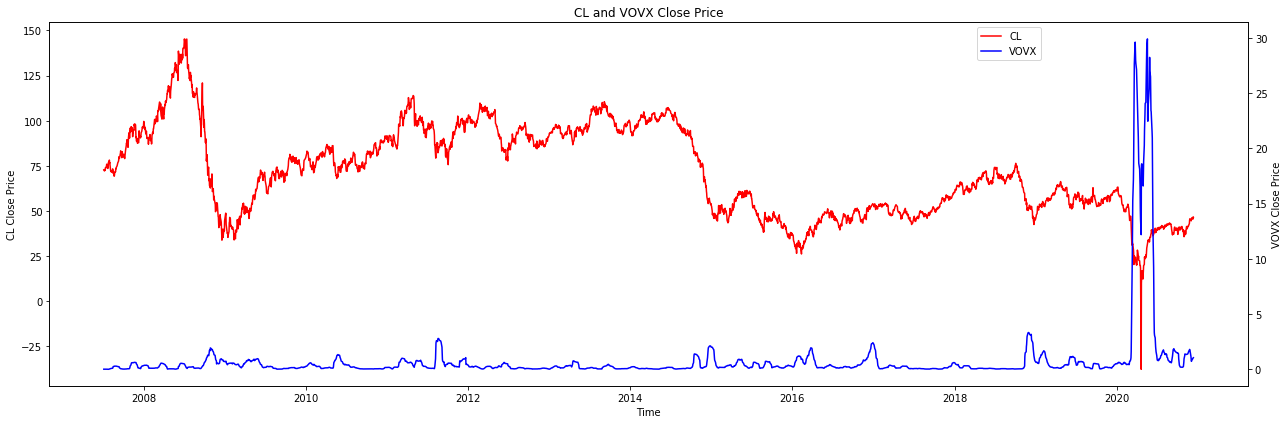

In [68]:
vv_viz(future_df=cl_df,future_name='CL',future_col='Settle',vv_df=vovx_df,vv_name='VOVX',vv_col='Close');

We can see the dates are more closely aligned than GC and VGNZ because CL and OVX began recording data around the same time. The standard deviation of the CL close price is far less than the standard deviation of the other two futures. This is likely because the range is only about 180, whereas the range of the other two futures is on the order of 1000's. 

The time series graph demonstrates peaks in VOVX during periods of contraction for CL. This can be clearly observed during roughly 6 peaks in VOVX found in this time series. Clearly, the crash during negative oil prices dwarfs all other peaks. This is not entirely surprising due to the unprecedented nature of this event. The relationship between CL and VOVX when CL is increasing is less clear. There does not appear to be a negative relationship, but rather, a period of steady VOVX typically corresponding to an increasing CL.

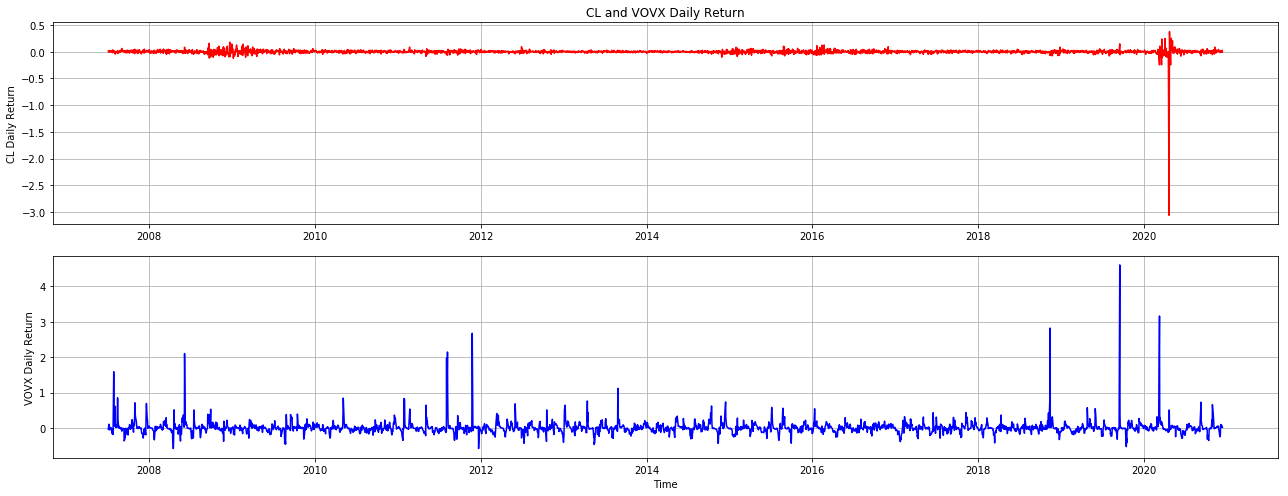

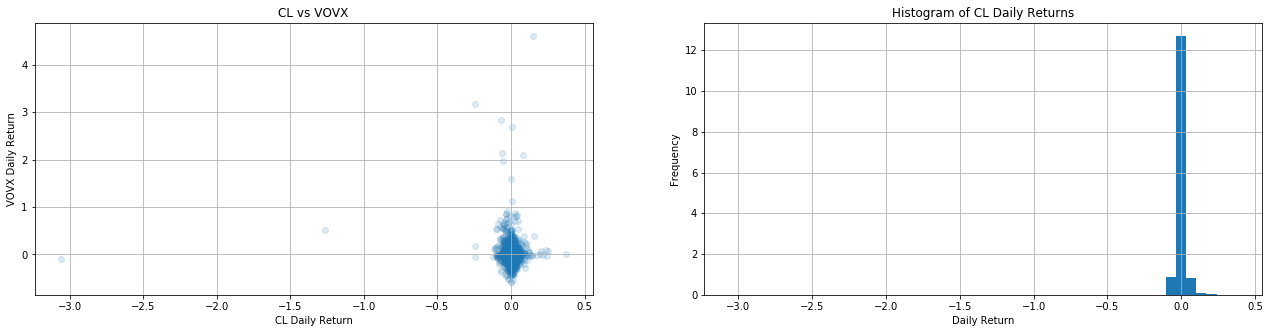



CL Daily Return Skewness: -35.10059689876534
CL Daily Return Kurtosis: 1626.5705891577522


Linear correlation of Returns between VOVX and CL


,CL,VOVX
CL,1,-0.02983
VOVX,-0.02983,1




Rank correlation of Returns between VOVX and CL


,CL,VOVX
CL,1,-0.00984
VOVX,-0.00984,1


In [91]:
vv_corr_hist(future_df=cl_df,future_name='CL',future_col='Settle',vv_df=vovx_df,vv_name='VOVX',vv_col='Close');

Investigation into the correlation confirms visual interpretation that there is slight negative relationship between VOVX and CL. The relationship is likely muted during the periods where CL does not experience a contraction. The scatterplot vaguely demonstrates this muted negative relationship. However, the rank correlation suggests the negative relationship is weaker than the linear correlation concludes when outliers are discounted.

The histogram is not very informative, but does confirm that the daily returns of CL clearly do not follow a normal distribution. The negative skewness is confirmed by the additional weight on the right side of the graph and the longer tail on the left side of the graph. The large kurtosis affirms this data has much longer tails than the normal distribution.

In [70]:
vovx_df,cl_df = vv_granger_mr(future_df=cl_df,future_name='CL',future_col='Settle',vv_df=vovx_df,vv_name='VOVX',vv_col='Close',lag_num=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0212  , p=0.3123  , df_denom=3380, df_num=1
ssr based chi2 test:   chi2=1.0221  , p=0.3120  , df=1
likelihood ratio test: chi2=1.0220  , p=0.3121  , df=1
parameter F test:         F=1.0212  , p=0.3123  , df_denom=3380, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3604  , p=0.6975  , df_denom=3377, df_num=2
ssr based chi2 test:   chi2=0.7218  , p=0.6971  , df=2
likelihood ratio test: chi2=0.7217  , p=0.6971  , df=2
parameter F test:         F=0.3604  , p=0.6975  , df_denom=3377, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2810  , p=0.8392  , df_denom=3374, df_num=3
ssr based chi2 test:   chi2=0.8447  , p=0.8387  , df=3
likelihood ratio test: chi2=0.8446  , p=0.8388  , df=3
parameter F test:         F=0.2810  , p=0.8392  , df_denom=3374, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2667  , p=0.

The granger casuality test concludes past values of VOVX does not contain statistically significant information about current values of CL. This is not terribly surprising given we only observe a relationship between CL and VOVX during sharp decreases in CL. The results of the granger casuality test does not mean there is not a relationship to be utilized, it is simply another data point in the investigation.

The ADF test and Hurst Exponent conclude the VOVX demonstrates mean reversion. The Hurst exponent is only slightly below 0.5, which is not a strong endorsement of mean reversion, but it does satisfy the criteria. Overall, it appears there is some mean reversion in VOVX which can be utilized to generate trading signals.

As observed for ES and VVIX, the relationship between CL and VOVX appears to be different during days of positive and negative CL returns. Therefore, I will re-evaluate the relationship between CL and VOVX based on this filter.

In [92]:
# Divide CL in daily negative and positive returns
cl_pos = cl_df[cl_df['Pct_Change'] >= 0][['Pct_Change','Settle']]
cl_neg = cl_df[cl_df['Pct_Change'] < 0][['Pct_Change','Settle']]

# filter OVX by the same dates
vovx_pos = vovx_df.loc[cl_pos.index,:][['Pct_Change','Close']]
vovx_neg = vovx_df.loc[cl_neg.index,:][['Pct_Change','Close']]

# Merge the data and rename the columns
vovx_cl_neg = pd.merge(cl_neg,vovx_neg, how='inner', left_index=True, right_index=True)
vovx_cl_pos = pd.merge(cl_pos,vovx_pos, how='inner', left_index=True, right_index=True)

vovx_cl_neg.columns = ['CL','Settle','VOVX','Close']
vovx_cl_pos.columns = ['CL','Settle','VOVX','Close']

In [93]:
print("Linear Correlation for positive return days:")
plot_corr_matrix(vovx_cl_pos[['CL','VOVX']],'pearson',4)

print("Linear Correlation for negative return days:")

plot_corr_matrix(vovx_cl_neg[['CL','VOVX']],'pearson',4)

Linear Correlation for positive return days:


,CL,VOVX
CL,1,0.1199
VOVX,0.1199,1


Linear Correlation for negative return days:


,CL,VOVX
CL,1,-0.0705
VOVX,-0.0705,1


As expected, there is a slight negative relationship for negative return days. We did not expect this to be a strong negative correlation, because this relationship only manifested itself during large spikes in VOVX. The linear correlation for positive return days is positive and a larger magnitude than expected. This is unexpected because we did not observe a positive relationship in the time series.

In [94]:
print("Rank Correlation for positive return days:")
plot_corr_matrix(vovx_cl_pos[['CL','VOVX']],'kendall',4)

print("Rank Correlation for negative return days:")

plot_corr_matrix(vovx_cl_neg[['CL','VOVX']],'kendall',4)

Rank Correlation for positive return days:


,CL,VOVX
CL,1,0.0005
VOVX,0.0005,1


Rank Correlation for negative return days:


,CL,VOVX
CL,1,-0.0332
VOVX,-0.0332,1


The rank correlation reaffirms our expectations for CL negative return days. When the outliers are discounted, the negative relationship during negative return days is weaker, but still apparent. This provides additional confidence developing a buy signal by utilizing a spike in VOVX. The rank correlation si roughly zero for days of positive return when outliers are discounted. This result of zero correlation for days of positive CL return is more in line with our expectations based on the behavior demonstrated in the time series plot.

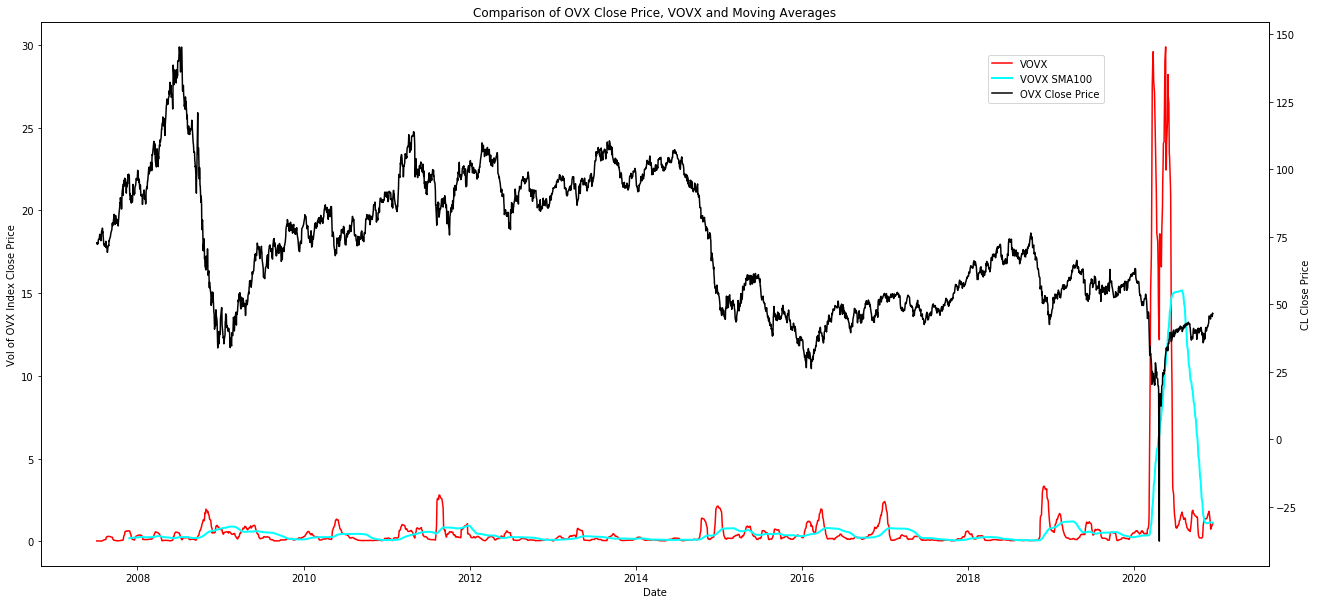

In [97]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(22, 10)

ax2 = ax1.twinx()

ax1.plot(vovx_df.index,vovx_df['Close'],color='red')
ax1.plot(vovx_df.index,vovx_df['Close'].rolling(100).mean(),color='cyan',linewidth=2)
ax1.set_ylabel('Vol of OVX Index Close Price')
ax1.set_xlabel('Date')

ax2.plot(cl_df.index,cl_df['Settle'],color='black')
ax2.set_ylabel('CL Close Price')
ax2.set_title('Comparison of OVX Close Price, VOVX and Moving Averages')

fig.legend(labels=['VOVX','VOVX SMA100','OVX Close Price'], bbox_to_anchor=[0.70,0.77])
plt.show()

As previously mentioned, the peaks in the VOVX correspond to CL price declines. While the three tests conducted do not strongly suggest the VOVX demonstrates mean reversion as clearly as the VVIX, these peaks still appear to have mean reverting beahavior. Therefore, this mean reversion can be used to develop a buy signal. Similar to ES, a buy signal will be triggered for CL once the VOVX breaches the 90th quantile threshold and the difference between the current day and SMA100 VOVX is smaller than the day before. This relationship is reinforced by the correlation analysis for CL negative daily returns.

An indicator for a sell signal is less clear. There does not appear to be any steady decline in VOVX corresponding to an increase in CL which was roughly apparent for ES and VVIX. The rank correlation of positive day CL returns concluded roughly zero correlation. Rather, a period of steady state behavior of VOVX seems to correspond to a steady increase in CL. Therefore, a sell signal will be based on upon two indicators. First, the VOVX must fall below the 5th quantile and the 25 day rolling beta of the SMA100 for VOVX must fall between -0.01 and 0.01. The second measure ensures this steady state behavior has been demonstrated for sufficient time to prevent premature sell signals.

## CL Trading Signals ##

Merge CL and VOVX daily prices to develop the trading signals.

In [126]:
vovx_format = vovx_df[['Close']]
vovx_format.rename(columns={'Close':'Index_Close'},inplace=True);

cl_format = cl_df[['Volume','Previous Day Open Interest','Settle','Pct_Change']]

merge = pd.merge(vovx_format,cl_format, how='inner', left_index=True, right_index=True)
vovx_cl = merge.dropna(how='any')

The quantiles of VOVX are as follows:

In [127]:
vovx_format['Index_Close'].quantile(np.arange(0.05,1.0,0.05))

0.05    0.037301
0.10    0.049303
0.15    0.060922
0.20    0.073682
0.25    0.092246
0.30    0.112519
0.35    0.134353
0.40    0.160100
0.45    0.184394
0.50    0.217292
0.55    0.255192
0.60    0.293617
0.65    0.359611
0.70    0.446507
0.75    0.540542
0.80    0.648002
0.85    0.824393
0.90    1.122001
0.95    1.743470
Name: Index_Close, dtype: float64

Compute the trading indicators used to trigger buy and sell signals.

In [128]:
# Compute SMA and its difference with the current price level
vovx_cl['VV_SMA100'] = vovx_cl['Index_Close'].rolling(100).mean()
vovx_cl['VV_SMA_Location'] = vovx_cl['Index_Close'] - vovx_cl['VV_SMA100']

# compute rolling beta
rolling = ols.PandasRollingOLS(y=vovx_cl['VV_SMA100'], x= np.arange(0,len(vovx_cl['VV_SMA100']),1), window=25)
vovx_cl['Rolling_Beta'] = rolling.beta

# categorize each day based on its quantile of VOVX
upper_band1 = 1.12
upper_band2 = 0.64
lower_band1 = 0.074
lower_band2 = 0.037

vovx_cl['VV_Location'] = np.where(vovx_cl['Index_Close'] > upper_band1, 5, 
                                 np.where(vovx_cl['Index_Close'] > upper_band2, 4,
                                 np.where(vovx_cl['Index_Close'] > lower_band1, 3,
                                 np.where(vovx_cl['Index_Close'] > lower_band2, 2, 1))))

# initialized the trade column and drop any null rows as a result of computing the moving averages
vovx_cl['Trade'] = 0
vovx_cl.dropna(how='any',inplace=True)

Generate the buy and sell signals.

In [129]:
trade_cl_df = vovx_cl.reset_index()

# iterate through each row
for index, row in trade_cl_df.iloc[:,:].iterrows():
    
    if index == 0:
        continue 
        
#   buy signal logic  
    if row['VV_Location'] == 5 and (row['VV_SMA_Location'] < trade_cl_df.loc[index-1,'VV_SMA_Location']):
        trade_cl_df.loc[index,'Trade'] = 1
        
#   sell signal logic  
    elif row['VV_Location'] == 1 and (-0.01 <= row['Rolling_Beta'] and row['Rolling_Beta'] <= 0.01):
        trade_cl_df.loc[index,'Trade'] = -1
   
# build a buy and sell signal data sets for graphing purposes
buy = trade_cl_df[trade_cl_df['Trade'] == 1]
sell = trade_cl_df[trade_cl_df['Trade'] == -1]

Plot the buy and sell signals over time series of the CL to assess the timing of these signals.

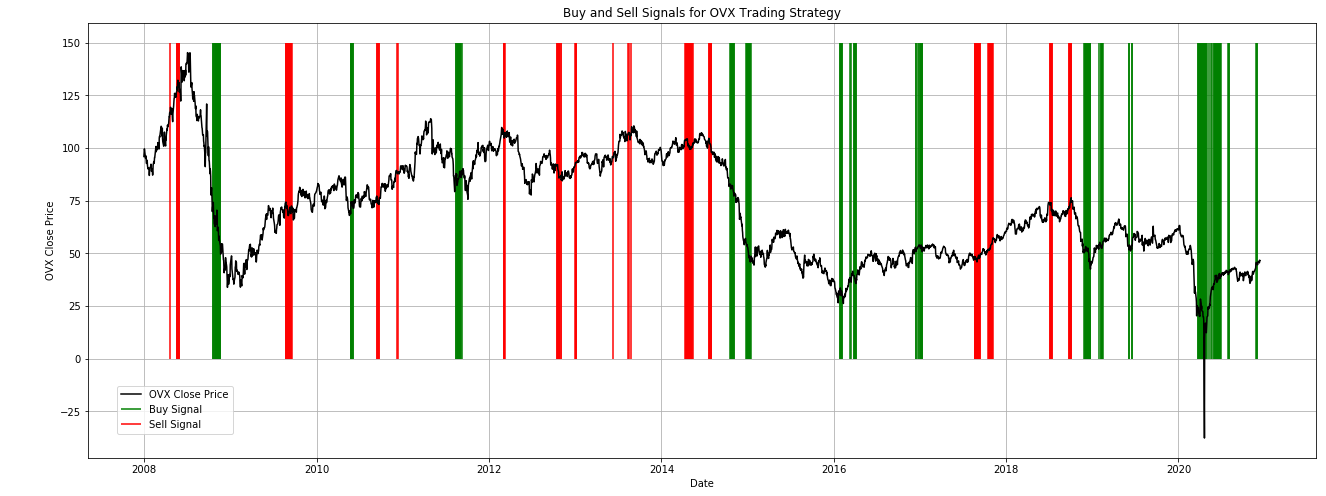

In [130]:
fig, (ax1) = plt.subplots()
fig.set_size_inches(22, 8)


ax1.plot(trade_cl_df['DATE'],trade_cl_df['Settle'],color='black')
ax1.vlines(x=buy['DATE'],ymin=0,ymax=150,color='g')
ax1.vlines(x=sell['DATE'],ymin=0,ymax=150,color='r')
ax1.set_xlabel('Date')
ax1.set_ylabel('OVX Close Price')
ax1.set_title('Buy and Sell Signals for OVX Trading Strategy')

fig.legend(labels=['OVX Close Price','Buy Signal','Sell Signal'], bbox_to_anchor=[0.15,0.2])
ax1.grid()

This graph demonstrates the buy and sell signals for CL based on the VOVX indicators. Inspection of the buy signals reveal this method effectively identifies period of price contraction for CL and triggers buy signals accordingly. Some of the buy signals are slightly premature, but they still effectively identify declines in CL. There are some smaller drops which do not trigger buy signals and this is likely because these smalls drops did follow a larger spike in VOVX.

Similarly, the sell signals are timed reasonably well. The first sell signal precedes a sharp drop in CL. The block of sell signals in the beginning of 2014 are well timed before the crash in ES price. Finally, the sell signals occuring in 2018 also precede a decline in ES price. The remaining sell signals are not particularly advantageous and can be re-examined in future analysis.

Again, it is important to note that these signals were developed and tested on the same data, therefore, these signals must first tested on out of sample data to determine their efficacy. It is reasonable expect spikes in VOVX to correspond to drops in CL, so we can be pretty confident in the buy signals. The sell signals will have to perform well out of sample before we can develop similar confidence.

## 6. Conclusion ##

In summary, three future contracts and their corresponding Vol of Vol indexes were analyzed to determine if these indexes could help inform the directionality of the underlying future. The pairs tested were GC and VGNZ, ES and VVIX, and CL and VOVX. For each pair, the descriptive statistics were analyzed for the future contract and the time series of the pairs were plotted. Next, the time series of the daily returns were graphed, along with the pairwise correlation and histogram of daily returns for the future. The granger casuality test was conducted for the daily returns of the pair and three mean reversion tests were conducted on the Vol of Vol index.

At the end of this exploratory data analysis it was concluded there were not clear trading indicators for GC and VGNZ. For the pairs ES and VVIX and CL and VOVX it was concluded there were signals to be utilized. Further analysis of the correlation were conducted for days of positive and negative return for each future in order to more effectively develop buy and sell signals. Finally, buy and sell signals were developed and plotted over the time series plot of each future to assess their timing. Initial results appear good, although, both tests were only in sample and, therefore, out of sample tests must be conducted before conclusions can be drawn about the efficacy of these signals.

Further work includes considering trading sizes, position limits, stop losses, transaction costs and slippage. Additionally, more research can be conducted regarding signals for each pair such as investigating a time series forecasting model that a granger causality test most frequently informs. This could potentially uncover trading signals for the GC VGNZ pair. Other technical indicators could be investigated for developing buy or sell signals. This can initially be developed with in sample data, but an out of sample test must be conducted before we can be confidence about this strategy.